<a href="https://colab.research.google.com/github/TapasKumarDutta1/IEEE-CIS-Fraud/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm import tqdm
from IPython.core.display import Image
from matplotlib import pyplot as plt
import seaborn as sns
import gc
import os
import pandas as pd
import numpy as np

Getting data

In [ ]:
os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
trn = pd.read_csv("train_transaction.csv.zip")
tst = pd.read_csv("test_transaction.csv.zip")
trn_idn = pd.read_csv("train_identity.csv.zip")
tst_idn = pd.read_csv("test_identity.csv.zip")

In [ ]:
trn.head()

TransactionID  isFraud  TransactionDT  ...  V337 V338  V339
0        2987000        0          86400  ...   NaN  NaN   NaN
1        2987001        0          86401  ...   NaN  NaN   NaN
2        2987002        0          86469  ...   NaN  NaN   NaN
3        2987003        0          86499  ...   NaN  NaN   NaN
4        2987004        0          86506  ...   0.0  0.0   0.0

[5 rows x 394 columns]

In [ ]:
trn_idn.head()

TransactionID  id_01  ...  DeviceType                     DeviceInfo
0        2987004    0.0  ...      mobile  SAMSUNG SM-G892A Build/NRD90M
1        2987008   -5.0  ...      mobile                     iOS Device
2        2987010   -5.0  ...     desktop                        Windows
3        2987011   -5.0  ...     desktop                            NaN
4        2987016    0.0  ...     desktop                          MacOS

[5 rows x 41 columns]

In [ ]:
train = trn.merge(trn_idn, on="TransactionID", how="left")
test = tst.merge(tst_idn, on="TransactionID", how="left")

In [ ]:
print(train.shape)
print(trn.shape)
print(trn_idn.shape)

(590540, 434)
(590540, 394)
(144233, 41)


In [ ]:
del([trn,tst,trn_idn,tst_idn])
gc.collect()

11

In [ ]:
a = list(train.filter(regex="id"))
b = list(test.filter(regex="id"))
dk = {}
for i, j in zip(a, b):
    dk[j] = i
test.rename(columns=dk, inplace=True)

Checking nan

In [ ]:
ls = list(test)
ln = len(train)
dk = {}
for col in ls:
    percent = 100 * train[col].isna().sum() / ln
    dk[col] = percent
df = pd.DataFrame(dk, index=[1])
df = df.T
df.columns = ["nan"]
df["columns"] = df.index
df = df.reset_index(drop=True)
df

nan         columns
0     0.000000   TransactionID
1     0.000000   TransactionDT
2     0.000000  TransactionAmt
3     0.000000       ProductCD
4     0.000000           card1
..         ...             ...
428  76.126088           id_36
429  76.126088           id_37
430  76.126088           id_38
431  76.155722      DeviceType
432  79.905510      DeviceInfo

[433 rows x 2 columns]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


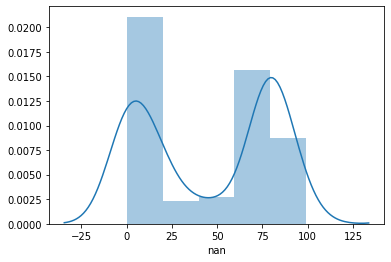

In [ ]:
sns.distplot(df['nan'])

Nan distribution across dataframe

In [ ]:
ls = list(test)
dk = {}
for col in ls:
    dk[col] = train[col].nunique()

df = pd.DataFrame(dk, index=[1])
df = df.T
df.columns = ["nunique"]
df["columns"] = df.index
df = df.reset_index(drop=True)
df

nunique         columns
0     590540   TransactionID
1     573349   TransactionDT
2      20902  TransactionAmt
3          5       ProductCD
4      13553           card1
..       ...             ...
428        2           id_36
429        2           id_37
430        2           id_38
431        2      DeviceType
432     1786      DeviceInfo

[433 rows x 2 columns]

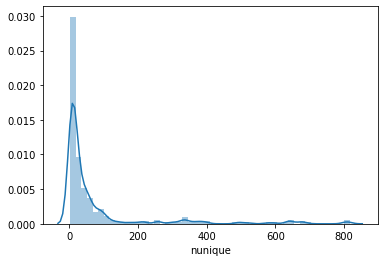

In [ ]:
sns.distplot(df['nunique'].loc[df['nunique']<np.percentile(df['nunique'].values,75)])

In [ ]:
del([df])
gc.collect()

27

Handling categorical data

In [ ]:
train.select_dtypes(include=object).nunique()

ProductCD           5
card4               4
card6               4
P_emaildomain      59
R_emaildomain      60
M1                  2
M2                  2
M3                  2
M4                  3
M5                  2
M6                  2
M7                  2
M8                  2
M9                  2
id_12               2
id_15               3
id_16               2
id_23               3
id_27               2
id_28               2
id_29               2
id_30              75
id_31             130
id_33             260
id_34               4
id_35               2
id_36               2
id_37               2
id_38               2
DeviceType          2
DeviceInfo       1786
dtype: int64

Since this dataset has imbalance checking if imbalance affects the column values

In [ ]:
def isdff(col):
    fraud = train.loc[train["isFraud"] == 1]
    n_f = train.loc[train["isFraud"] == 0].sample(fraud.shape[0])
    df = pd.concat([fraud, n_f], 0).reset_index(drop=True)
    num = min(df[col].nunique(), 10)
    x = df[col].value_counts().head(num)
    x.plot.bar()
    plt.show()
    y = train[col].value_counts().head(num)
    y.plot.bar()
    ls = list(set(y.index) - set(x.index))
    print(len(ls))
    print(ls)
    list(set(x.index) - set(y.index))
    del [df]
    gc.collect()

In [ ]:
categorical = (
    [
        "ProductCD",
        "card1",
        "card2",
        "card3",
        "card4",
        "card5",
        "card6",
        "addr1",
        "addr2",
        "P_emaildomain",
        "P_emaildomain_first",
        "P_emaildomain_second",
        "R_emaildomain",
        "DeviceInfo",
        "DeviceType",
    ]
    + ["id_0" + str(i) for i in range(1, 10)]
    + ["id_" + str(i) for i in range(10, 39)]
    + ["M" + str(i) for i in range(1, 10)]
)
categorical = set(categorical).intersection(set(list(test)))
categorical

{'DeviceInfo',
 'DeviceType',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'addr1',
 'addr2',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38'}

Checking Ms

In [ ]:
ls = train.filter(regex="M")
for col in ls:
    print(col)
    print(train[col].unique())
    print()

M1
['T' nan 'F']

M2
['T' nan 'F']

M3
['T' nan 'F']

M4
['M2' 'M0' nan 'M1']

M5
['F' 'T' nan]

M6
['T' 'F' nan]

M7
[nan 'F' 'T']

M8
[nan 'F' 'T']

M9
[nan 'F' 'T']



Ms seems like flags lets see if any flag fraud

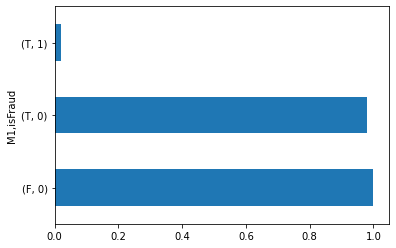

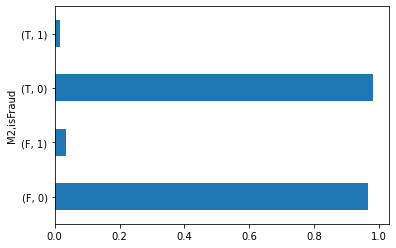

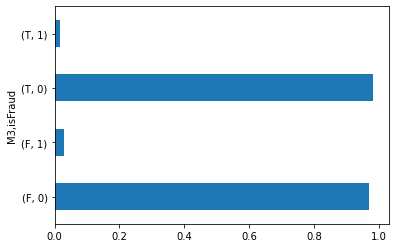

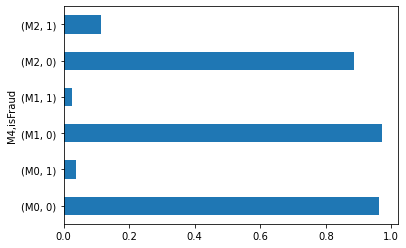

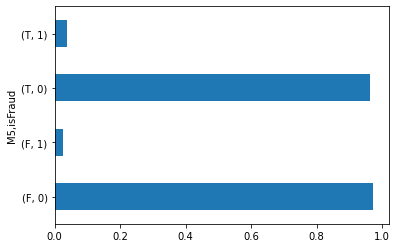

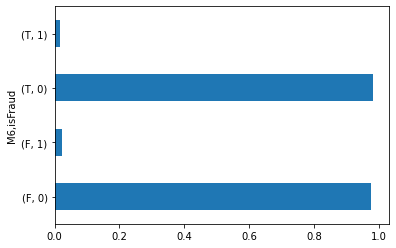

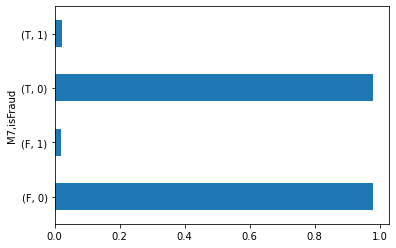

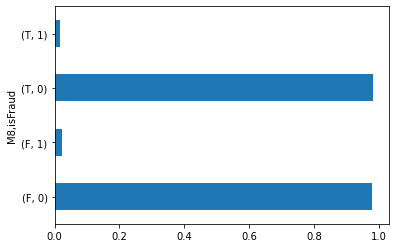

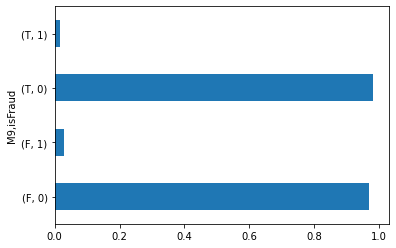

In [ ]:
ln = len(train)
dk = {}
for i in range(1, 10):
    col = "M" + str(i)
    (train.groupby([col])["isFraud"].value_counts(normalize=True)).plot.barh()
    plt.show()

checking cards

There are 195 countries and 25000 banks so card1 should be a bank and card3 or card5 should be country

In [ ]:
ls=train.filter(regex='card')
for col in ls:
  print(col)
  print(train[col].nunique())
  print()

card1
13553

card2
500

card3
114

card4
4

card5
119

card6
4



checking address

In [ ]:
ls=train.filter(regex='addr')
for col in ls:
  print(col)
  print(train[col].nunique())
  print()

addr1
332

addr2
74



Convert TransactionDT to day,month,year

In [ ]:
def time(df):
    df["day"] = df["TransactionDT"] // 86400
    df["week"] = df["TransactionDT"] // (86400 * 7)
    df["month"] = df["TransactionDT"] // (86400 * 30)
    return df


train = time(train)
test = time(test)

Lets start with Ds

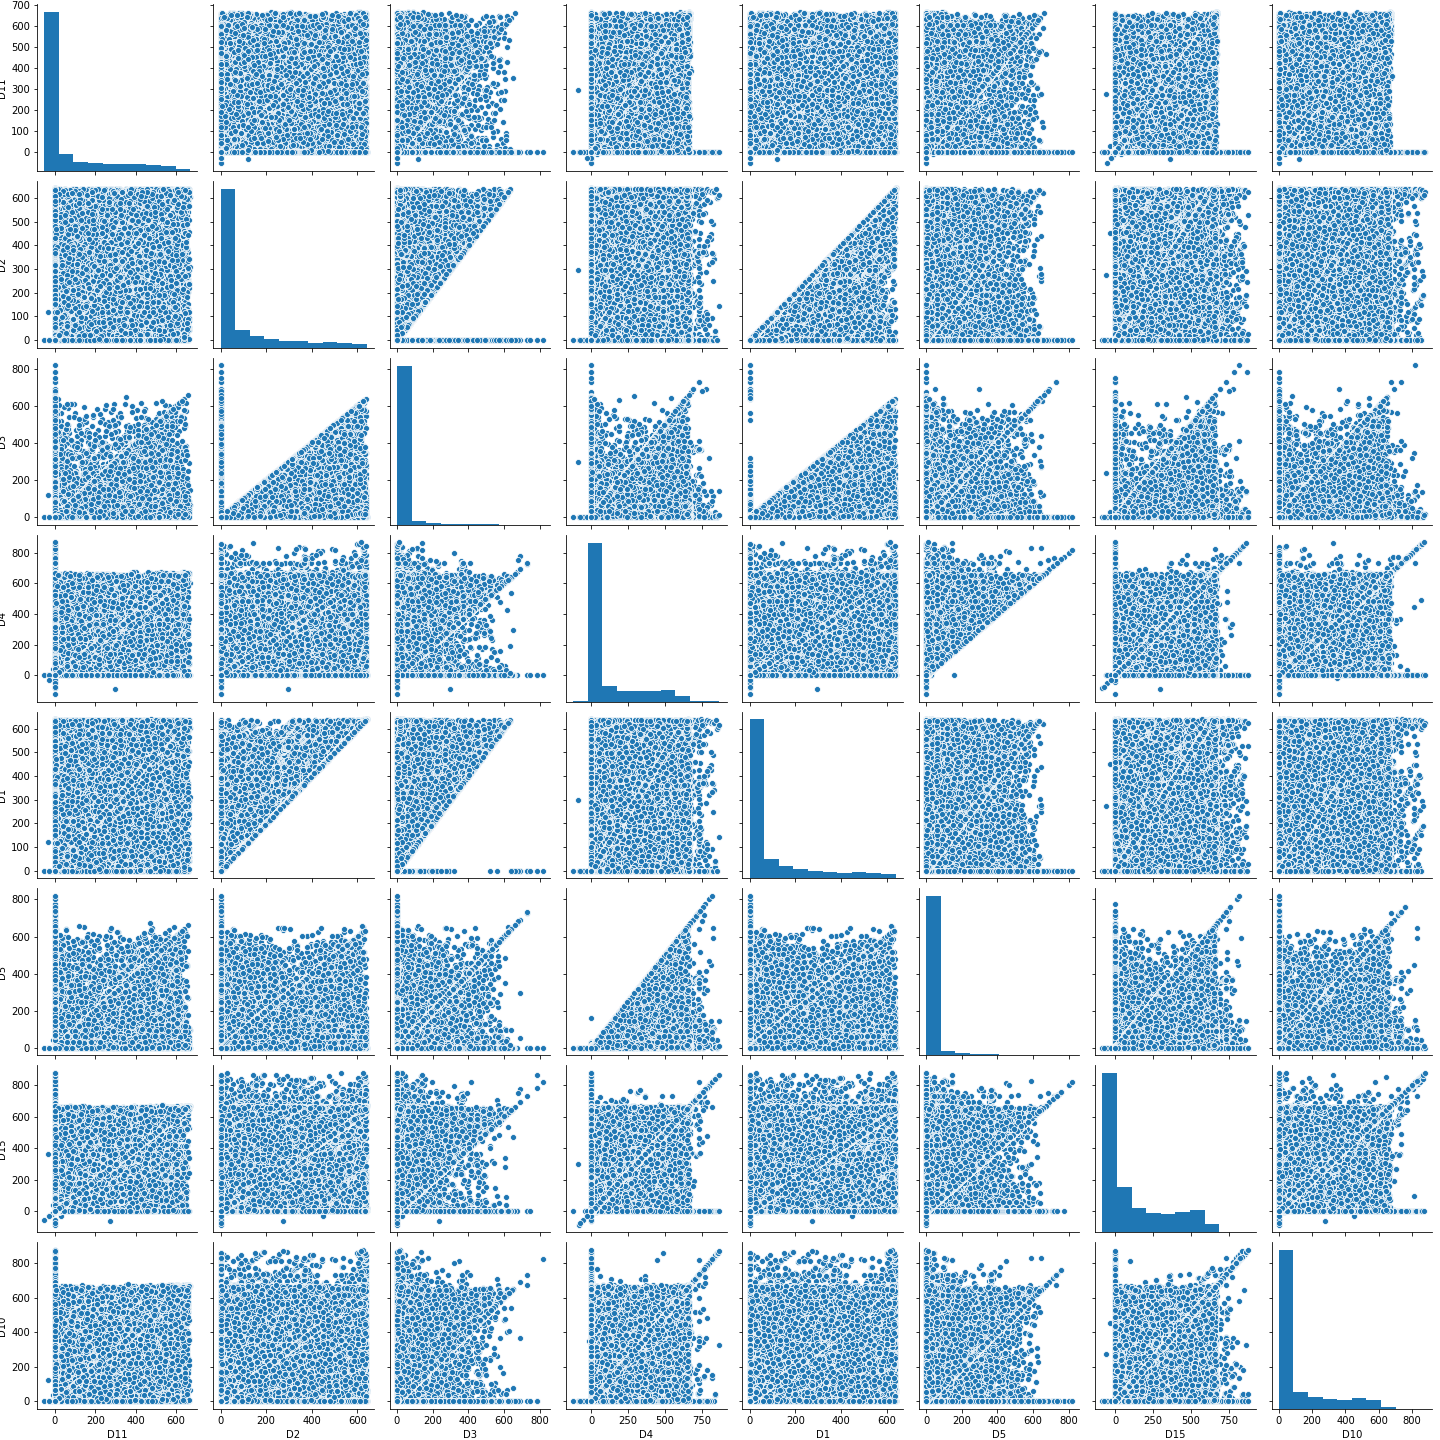

In [ ]:
numerical = ["TransactionAmt", "dist1", "dist2","day","week","year"] + ["C" + str(i) for i in range(1, 15)]+["D" + str(i) for i in range(1, 16)]+["V" + str(i) for i in range(1,340)]
numerical=list(set(list(train)).intersection(set(numerical)))
Image( filename ='D_pair_non_nan.png')

An interesting relation is that D2 is always greater than D3 except for D2 == 0

Also D1 is atleast as large as D2 if not more

Also D1 is larger than D3 except for when D1 == 0

Lets focus on these three

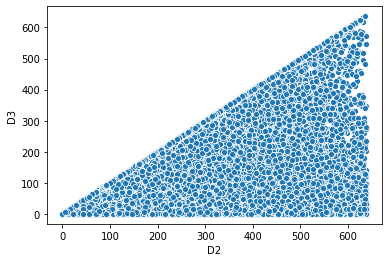

In [ ]:
sns.scatterplot(train['D2'],train['D3'])

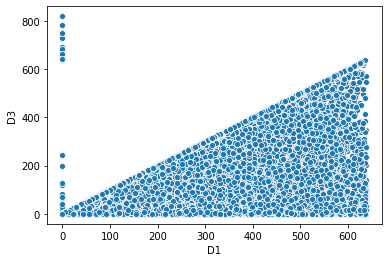

In [ ]:
sns.scatterplot(train['D1'],train['D3'])

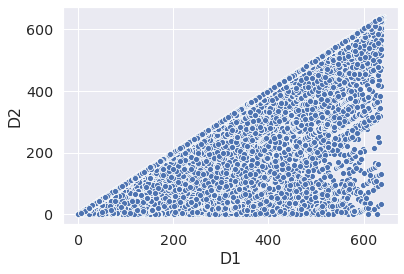

In [ ]:
sns.set(font_scale=1.3)
sns.scatterplot(train['D1'],train['D2'])

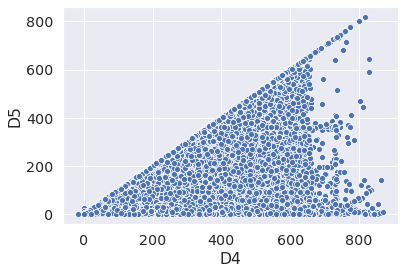

In [ ]:

sns.scatterplot(train['D4'],train['D5'])

In [ ]:
((set(numerical)-set(train[numerical].filter(regex='V')))-set(train[numerical].filter(regex='C')))-set(train[numerical].filter(regex='D'))

{'TransactionAmt', 'day', 'dist1', 'dist2', 'week'}

In [ ]:
categorical

{'DeviceInfo',
 'DeviceType',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'addr1',
 'addr2',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38'}

For referencing an individual lets use addr and card1

In [ ]:
train['id']=train['addr1'].astype(str)+train['card1'].astype(str)
test['id']=test['addr1'].astype(str)+test['card1'].astype(str)

I think D1 is the difference in days from date of issue of card and D3 is difference in days from previous transaction,V307 is cumulative of TransactionAmt for each individual.

To prove V307 is cumulative TransactionAmt we make a column new with TransactionAmt+V307 to check with next Transaction of the individual

In [ ]:
train['new']=train['TransactionAmt']+train['V307']

In [ ]:
train.loc[(train['isFraud']==1)&(train['D1']<train['day'])&(train['D1']!=0)][['D1','D2','D3','id','TransactionAmt','V307','day']].head(20)

D1   D2   D3          id  TransactionAmt        V307  day
5190   1.0  NaN  0.0     nan4504          83.742   83.742104    2
5749   1.0  NaN  0.0     nan4504          83.742   58.003700    2
6267   1.0  1.0  1.0   330.09500         200.000  426.000000    2
6269   1.0  1.0  0.0   330.09500         226.000  626.000000    2
8979   1.0  NaN  NaN     nan8755          30.633   14.138300    3
9785   1.0  1.0  1.0    nan10876          10.634   43.623299    3
9786   1.0  1.0  1.0     nan5812          10.634   14.380000    3
9788   1.0  1.0  0.0     nan5812          10.634   25.013901    3
9790   1.0  1.0  0.0     nan5812          10.634   35.647800    3
10136  1.0  1.0  1.0   194.05300         171.000  754.000000    3
10259  2.0  2.0  NaN   272.03821          20.000   15.000000    3
11613  2.0  NaN  2.0   299.08225         115.000  970.000000    3
11638  1.0  NaN  NaN     nan9633          24.168  193.343994    3
11645  1.0  NaN  NaN     nan9633          24.168  217.511993    3
11745  1.0  NaN  2.0     nan9633          24.168  145.007996    3
12429  2.0  2.0  1.0  299.011862         390.000  390.000000    4
12806  1.0  1.0  1.0     nan4504          48.940   24.349300    4
13080  1.0  1.0  0.0     nan4504          56.311   73.289497    4
13083  1.0  1.0  0.0     nan4504          56.311  129.600906    4
14024  1.0  1.0  1.0  191.013593         117.000  117.000000    4

Look at the third. Searching for day = 2-1(day-D1) we find one where V307 =0 and TransactionAmt = 83

In [ ]:
train.loc[(train['id']=='330.09500')&(train['day']==1)&(train['new']==426.000000)][['D1','D2','D3','id','TransactionAmt','V307','day']].head(20)

D1   D2   D3         id  TransactionAmt   V307  day
5081  0.0  0.0  1.0  330.09500           200.0  226.0    1

For the 12 from top

In [ ]:
train.loc[(train['id']=='299.08225')&(train['day']==1)&(train['new']==970.000000)][['D1','D2','D3','id','TransactionAmt','V307','day']].head(20)

D1  D2   D3         id  TransactionAmt   V307  day
4519  0.0 NaN  0.0  299.08225           443.0  527.0    1

In [ ]:
train['D3'].values[0] in list(train['D3'].values)

True

Lets see for how many this condition holds true

In [ ]:
fr = 0
agn = 0
for _, row in tqdm(train.loc[train["D3"] < train["day"]].iterrows()):
    df = train.loc[(train["day"] == (row["day"] - row["D3"]))]
    ls = list(df["new"].values)
    if row["V307"] in ls:
        fr += 1
    else:
        agn += 1

284517it [36:24, 130.27it/s]


In [ ]:
print(fr,agn)

111132 173385


Thus D3 is the difference in days from previous transaction and V307 is cumulative TransactionAmt for individual

Next lets prove D1 is difference in days from issue of card

To do so i will use 2 facts that


1.   When issuing a card its V307 should be 0
2.   Or V307 = TransactionAmt



Where D3 is nan it means it was the first transaction or it wasent noted or it is beyound our timeframe  and 0 means transaction was made the same date

In [ ]:
#           First transaction      D1 not zero means there is a difference from first transaction              if the difference is within timeframe
train.loc[(train['D3'].isna())&(train['D1']!=0)&(~train['D1'].isna())                                             &(train['D1']<train['day'])]                   [['D1','D2','D3','id','TransactionAmt','V307','day']]

D1     D2  D3          id  TransactionAmt      V307  day
5148      1.0    1.0 NaN   512.02917          25.000   25.0000    2
5411      1.0    NaN NaN  177.017541         100.000  300.0000    2
8979      1.0    NaN NaN     nan8755          30.633   14.1383    3
9437      2.0    2.0 NaN   264.01741         150.000  150.0000    3
10259     2.0    2.0 NaN   272.03821          20.000   15.0000    3
...       ...    ...  ..         ...             ...       ...  ...
590056  158.0  158.0 NaN   181.08695         150.000    0.0000  182
590061  157.0  157.0 NaN   315.04806         200.000    0.0000  182
590066  157.0  157.0 NaN   315.04806         200.000  200.0000  182
590070  180.0  180.0 NaN  330.017458          14.000   27.0000  182
590102  157.0  157.0 NaN   315.04806         200.000  400.0000  182

[4283 rows x 7 columns]

In [ ]:
train.loc[(train['D3'].isna())&(train['D1']==0)][['D1','D2','D3','id','TransactionAmt','V307','day']]

D1  D2  D3          id  TransactionAmt  V307  day
1       0.0 NaN NaN   325.02755          29.000   0.0    1
2       0.0 NaN NaN   330.04663          59.000   0.0    1
4       0.0 NaN NaN   420.04497          50.000   0.0    1
5       0.0 NaN NaN   272.05937          49.000   0.0    1
6       0.0 NaN NaN  126.012308         159.000   0.0    1
...     ...  ..  ..         ...             ...   ...  ...
590529  0.0 NaN NaN     nan5096          73.838   0.0  182
590530  0.0 NaN NaN  299.015066         400.780   0.0  182
590534  0.0 NaN NaN     nan5812          67.505   0.0  182
590536  0.0 NaN NaN  204.010444          39.500   0.0  182
590537  0.0 NaN NaN  231.012037          30.950   0.0  182

[252202 rows x 7 columns]

Thus our hypotheses holds mostly

Fill Ds with -999

In [ ]:
train[numerical].filter(regex='D').fillna(-999,inplace=True)
test[numerical].filter(regex='D').fillna(-999,inplace=True)

Next is Cs

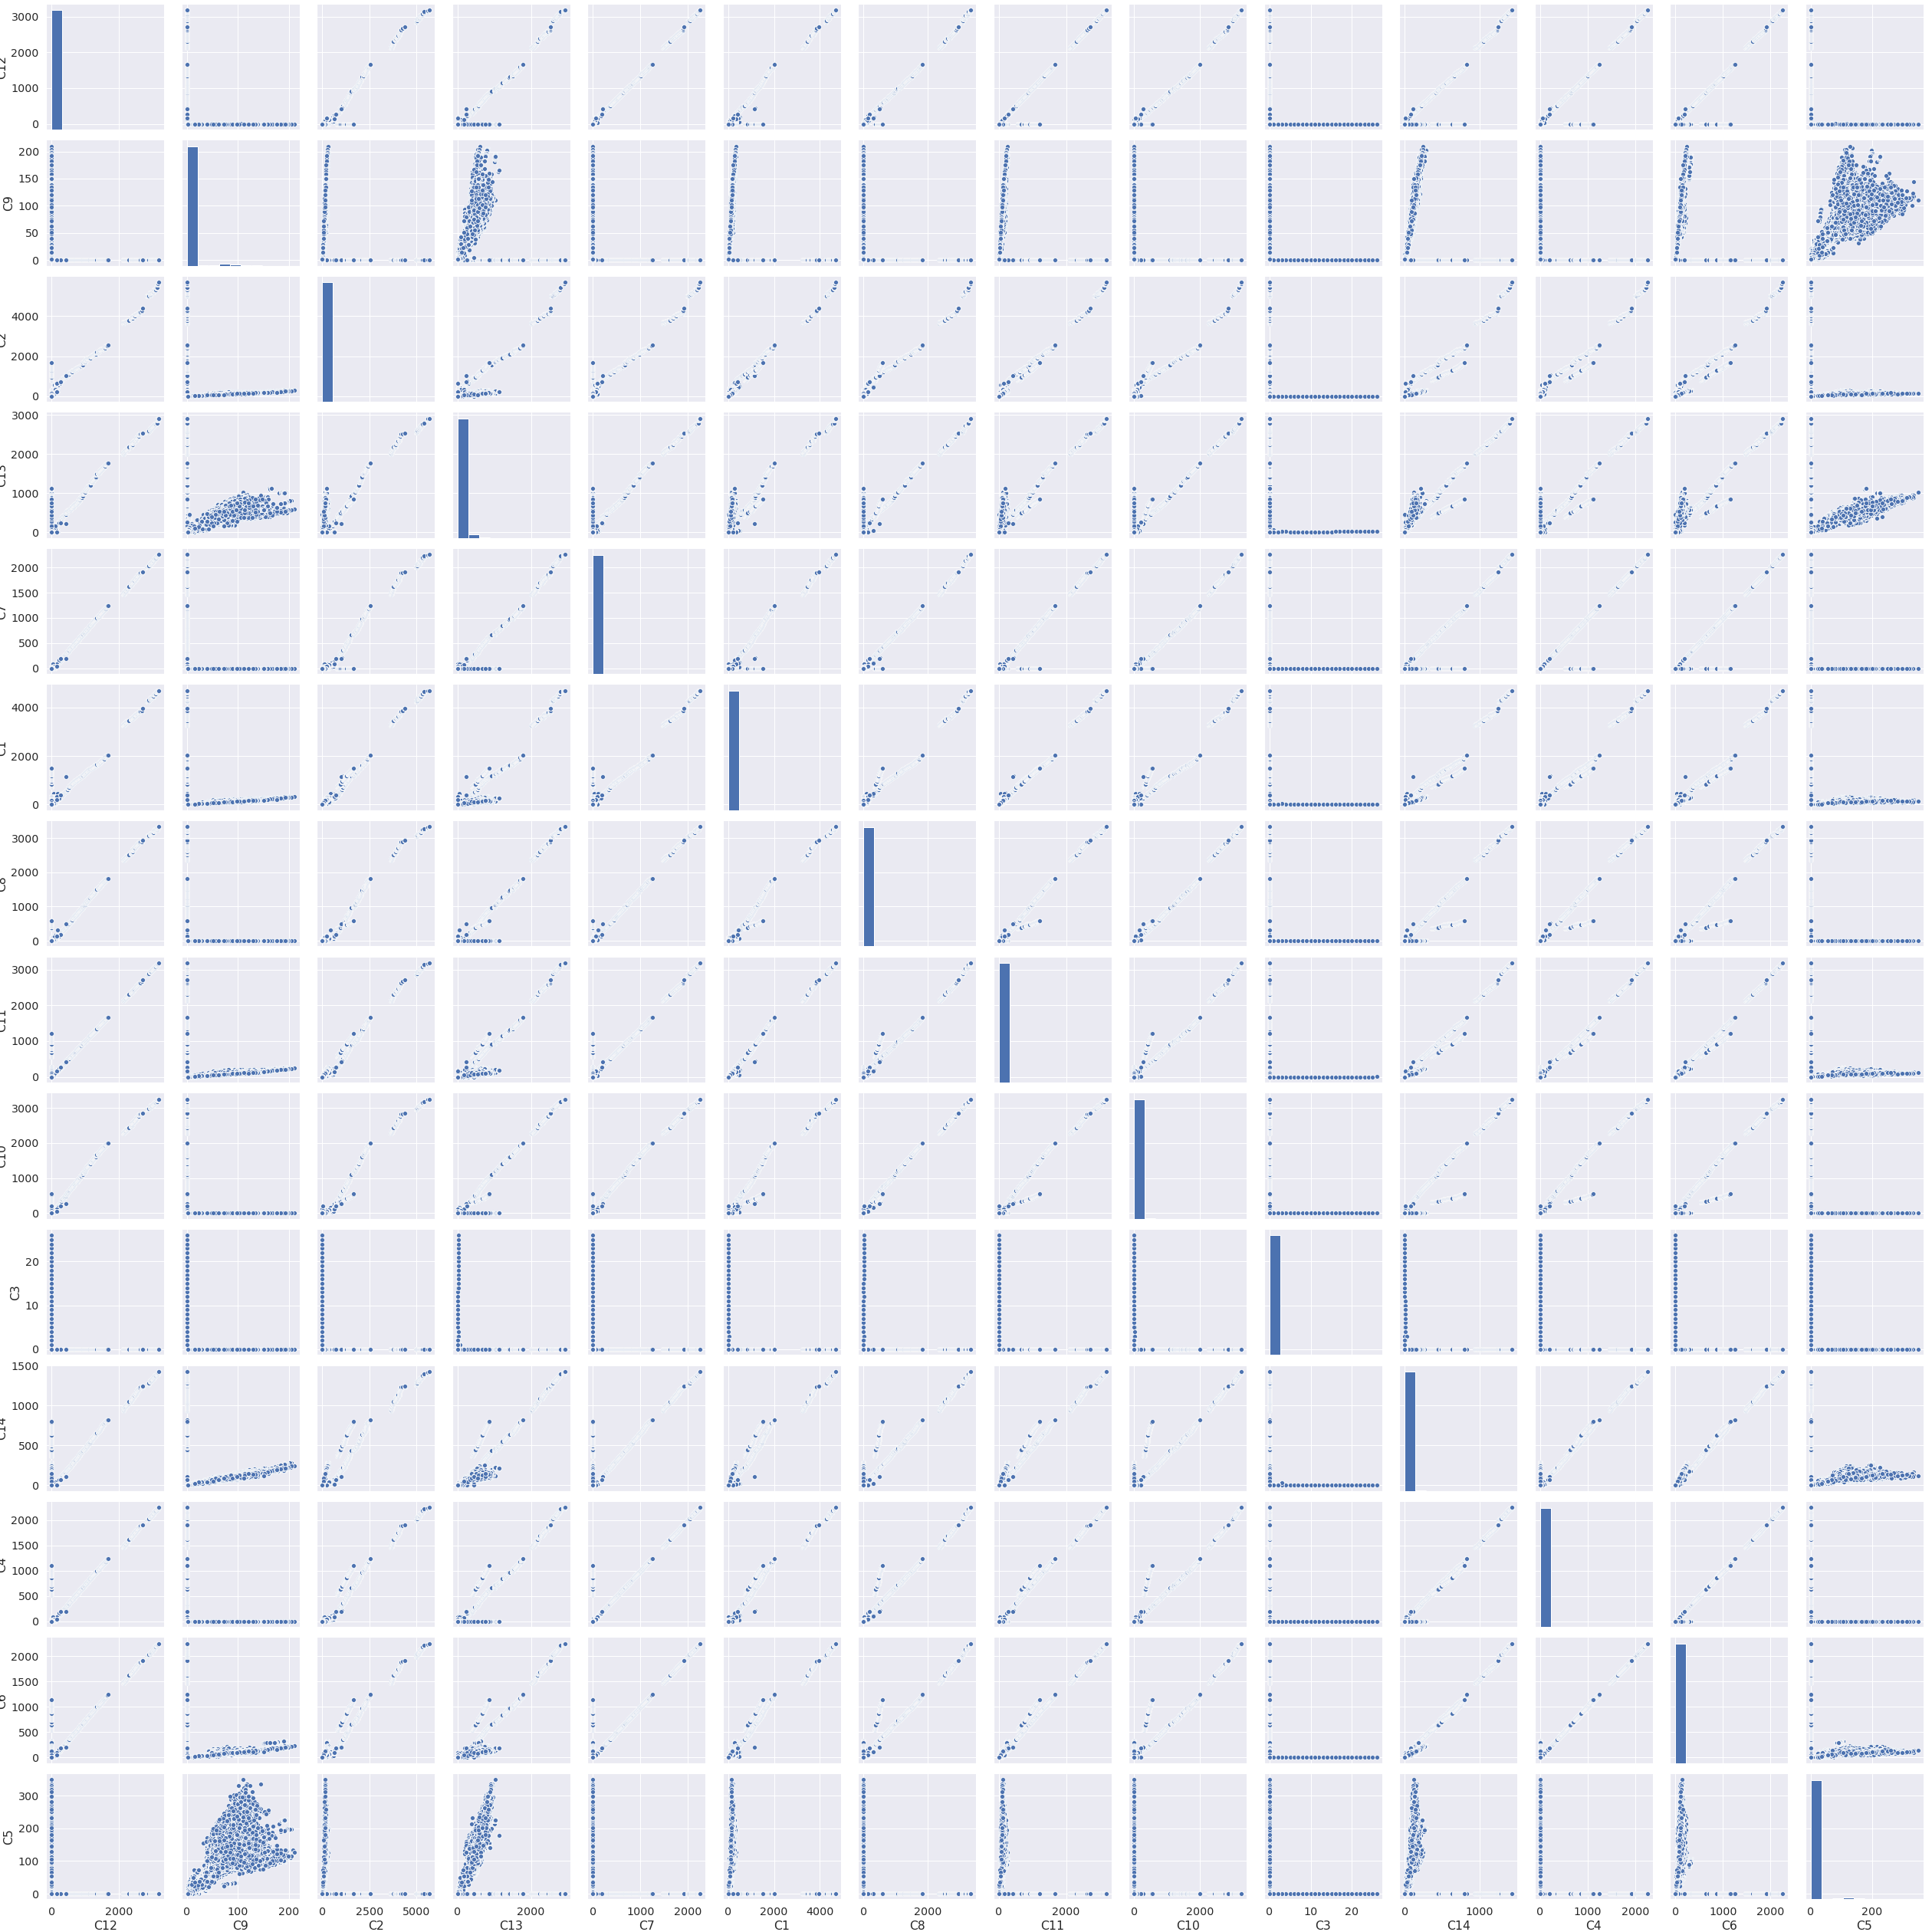

In [ ]:
Image( filename ='C_pair_non_nan.png')

In [ ]:
cs=list(set(numerical).intersection(set(list(train.filter(regex='C')))))
for c in cs:
  print(c)
  print(train[c].nunique())
  print()

C7
1103

C8
1253

C12
1199

C4
1260

C2
1216

C6
1328

C10
1231

C1
1657

C9
205

C11
1476

C5
319

C13
1597

C14
1108

C3
27



In [ ]:
train[cs].describe()

C7             C8  ...            C14             C3
count  590540.000000  590540.000000  ...  590540.000000  590540.000000
mean        2.848478       5.144574  ...       8.295215       0.005644
std        61.727304      95.378574  ...      49.544262       0.150536
min         0.000000       0.000000  ...       0.000000       0.000000
25%         0.000000       0.000000  ...       1.000000       0.000000
50%         0.000000       0.000000  ...       1.000000       0.000000
75%         0.000000       0.000000  ...       2.000000       0.000000
max      2255.000000    3331.000000  ...    1429.000000      26.000000

[8 rows x 14 columns]

Most has high std,mean and max value except for C3

Lets plot the cs with days

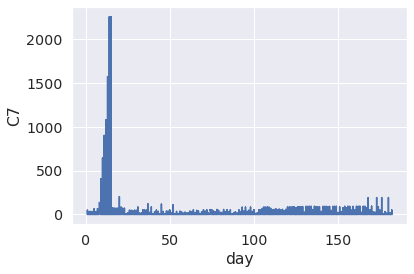

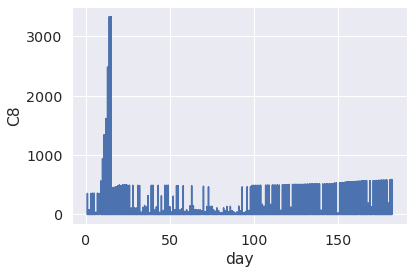

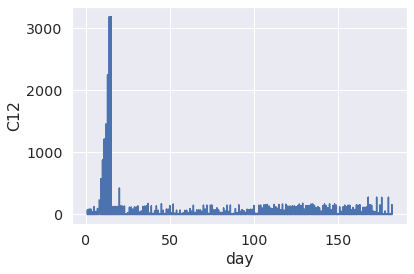

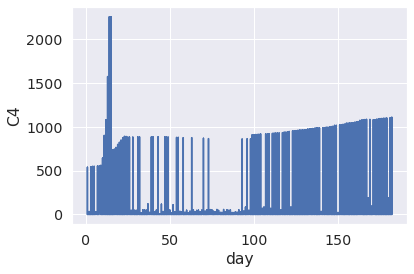

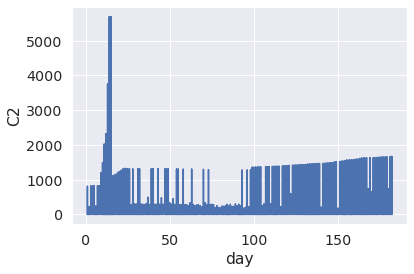

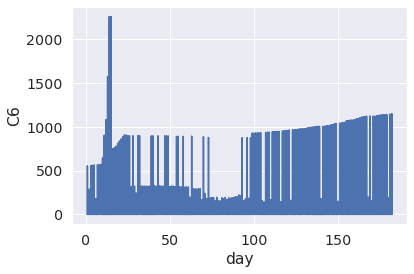

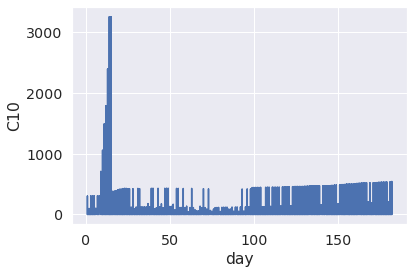

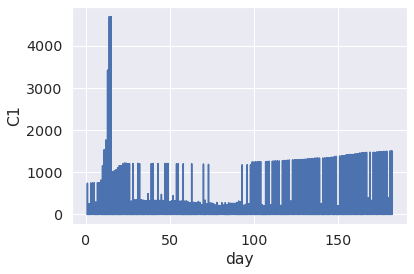

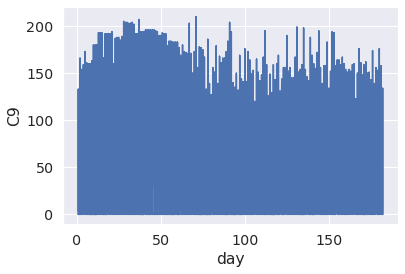

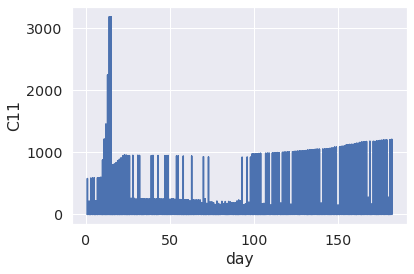

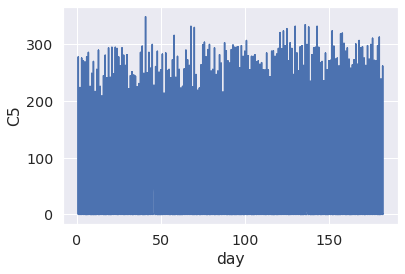

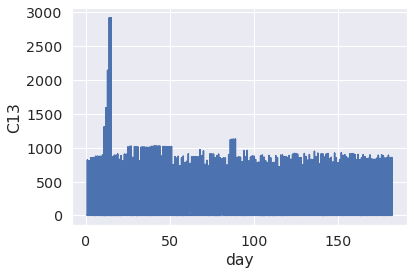

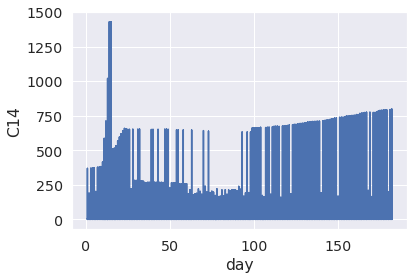

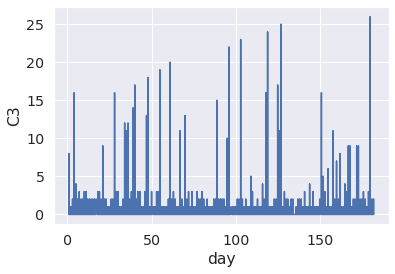

In [ ]:
for c in cs:
  plt.plot(train['day'],train[c])
  plt.xlabel('day')
  plt.ylabel(c)
  plt.show()

**Takeaway points**
1. D1 seemed to represent difference in date from a particular date unique for each user
2. D3 is difference in days between consecutive transactions
3. V307 is cumulative TransactionAmt
